<a href="https://colab.research.google.com/github/iambrookedrake/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Brooke_Drake_DSPT6_U2S1M3_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [82]:
##Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
##and the sale price was more than 100 thousand and less than 2 million.
subset = df[(df['BUILDING_CLASS_CATEGORY']== '01 ONE FAMILY DWELLINGS') & 
            (df['SALE_PRICE']>100000) & (df['SALE_PRICE']<2000000)]
print(subset.shape)
subset.head()

(3151, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [83]:
##Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
import datetime
from datetime import datetime, date, time
subset['month'] = subset['SALE_DATE']
subset['month'] = pd.to_datetime(subset['month'], infer_datetime_format=True)
subset['month']=subset['month'].dt.month
train = subset[subset['month'] < 4]
test = subset[subset['month'] == 4]
print(test.shape, train.shape)
print(subset.dtypes)

(644, 22) (2507, 22)
BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
month                               int64
dtype: object


In [84]:
##Do one-hot encoding of categorical features.
df.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,23040,23040,23040,23039,23039,23040,5201,22987,23040,23040
unique,5,11,44,10,146,22691,1724,3652,147,120
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,D4,100 JEROME STREET,4,0,D4,01/24/2019
freq,7494,19117,5061,11071,3408,6,99,7500,3408,480


In [85]:
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_CATEGORY', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','LAND_SQUARE_FEET','BUILDING_CLASS_AT_TIME_OF_SALE','SALE_DATE','EASE-MENT']
features = train.columns.drop(high_cardinality + [target] + ['month']).to_list()

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
print("Originial Train/Test Shape:", X_train.shape, X_test.shape)

import category_encoders as ce 

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test) # not fit_transform

print("One-hot Encoded Train/Test Shape:", X_train_enc.shape,X_test_enc.shape)

Originial Train/Test Shape: (2507, 12) (644, 12)
One-hot Encoded Train/Test Shape: (2507, 22) (644, 22)


In [86]:
X_train_enc

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,1,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,1,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,1,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,1,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,1,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,1,0,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,0,0,0,1,0,1,0,0,0,0,0,1,0,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,0,0,0,1,0,1,0,0,0,0,0,1,0,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,0,0,0,1,0,1,0,0,0,0,0,1,0,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


In [87]:
#k=what?
##Do feature selection with SelectKBest.
from sklearn.feature_selection import SelectKBest, f_regression
import warnings  
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
mae_list = []
for k in range(1, X_train_enc.shape[1] + 1):
  print(f'Using top {k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_enc, y_train)
  X_test_kbest = selector.transform(X_test_enc)
  model = LinearRegression()
  model.fit(X_train_kbest, y_train)
  y_pred = model.predict(X_test_kbest)
  mae = mean_absolute_error(y_pred, y_test)
  print(f'MAE: {mae}')
  mae_list.append(mae)

Using top 1 features
MAE: 183640.5858012459
Using top 2 features
MAE: 174495.91534327448
Using top 3 features
MAE: 175142.67817356435
Using top 4 features
MAE: 173620.36506521053
Using top 5 features
MAE: 174228.7197855156
Using top 6 features
MAE: 174011.32697173842
Using top 7 features
MAE: 169628.17852770645
Using top 8 features
MAE: 170425.58748586272
Using top 9 features
MAE: 169744.8407572128
Using top 10 features
MAE: 162186.9848578278
Using top 11 features
MAE: 163540.70748177456
Using top 12 features
MAE: 161621.69342187527
Using top 13 features
MAE: 161706.14838861104
Using top 14 features
MAE: 161706.14838860725
Using top 15 features
MAE: 161499.38081853554
Using top 16 features
MAE: 161410.7661456822
Using top 17 features
MAE: 161988.5193877035
Using top 18 features
MAE: 162006.25618751138
Using top 19 features
MAE: 162021.2438272787
Using top 20 features
MAE: 162021.24382727096
Using top 21 features
MAE: 162021.2438272847
Using top 22 features
MAE: 162021.24382728603


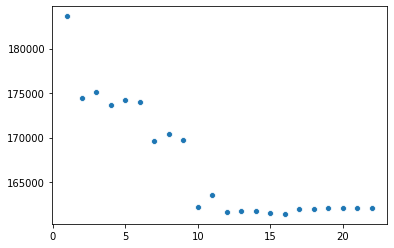

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=range(1, X_train_enc.shape[1] + 1), y=mae_list)

In [89]:
k=9
selector = SelectKBest(score_func=f_regression, k=k)
X_train_kbest = selector.fit_transform(X_train_enc, y_train)
X_test_kbest = selector.transform(X_test_enc)
X_train_kbest.shape, X_test_kbest.shape

((2507, 9), (644, 9))

In [90]:
X_train_enc.columns[selector.get_support()] #relevant k columns

Index(['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS', 'ZIP_CODE',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET'],
      dtype='object')

In [91]:
X_train_enc.columns[~selector.get_support()] #columns not in k

Index(['BOROUGH_4', 'BOROUGH_1', 'NEIGHBORHOOD_BEDFORD STUYVESANT',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

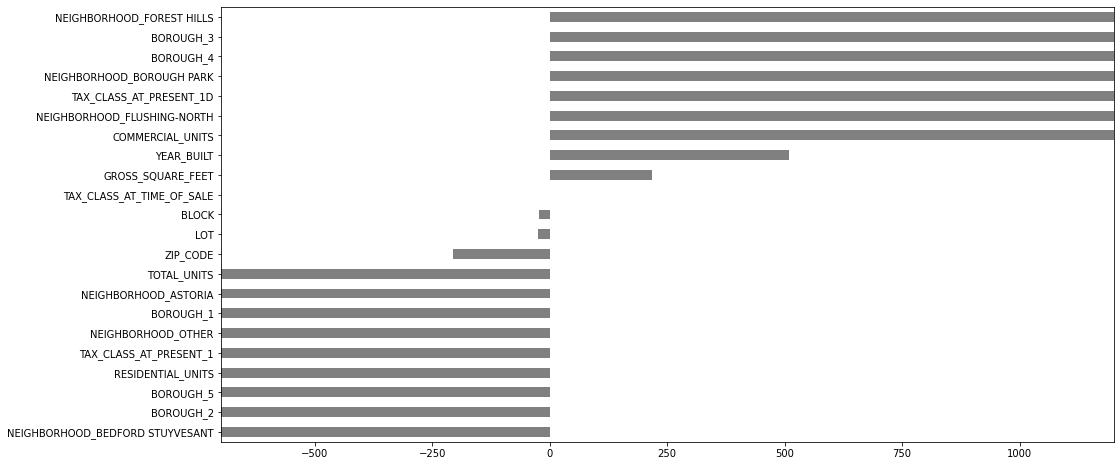

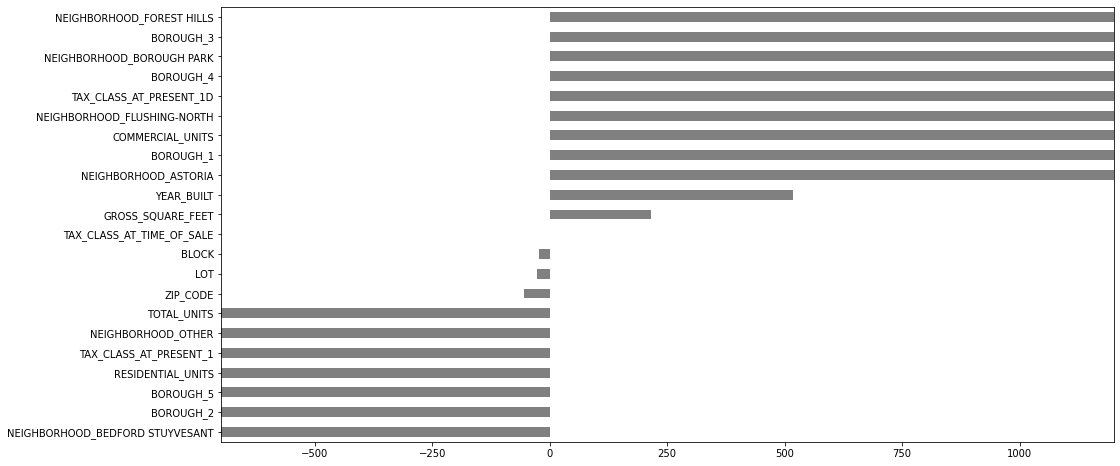

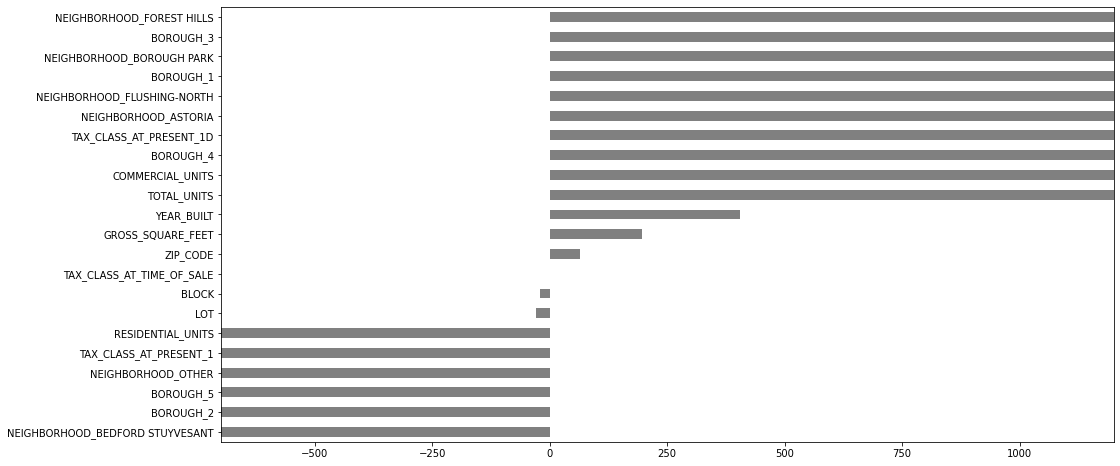

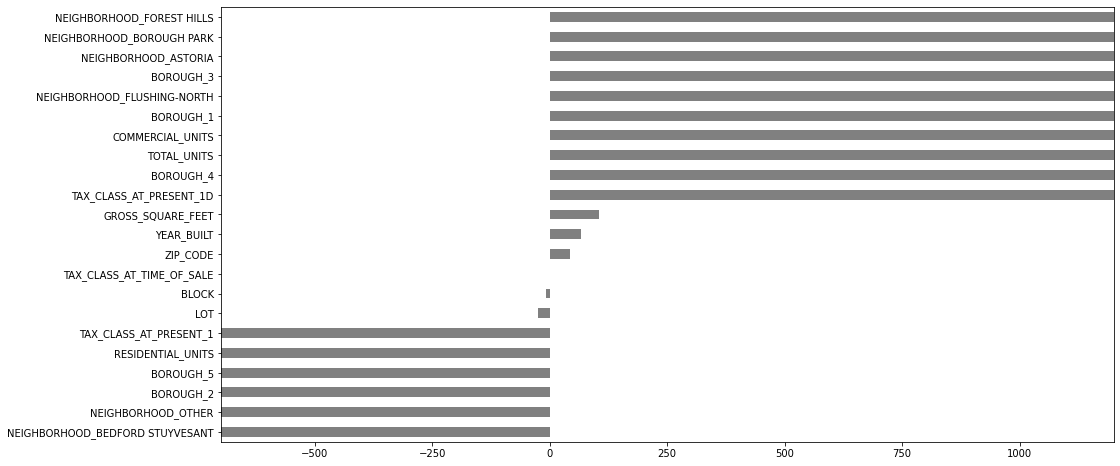

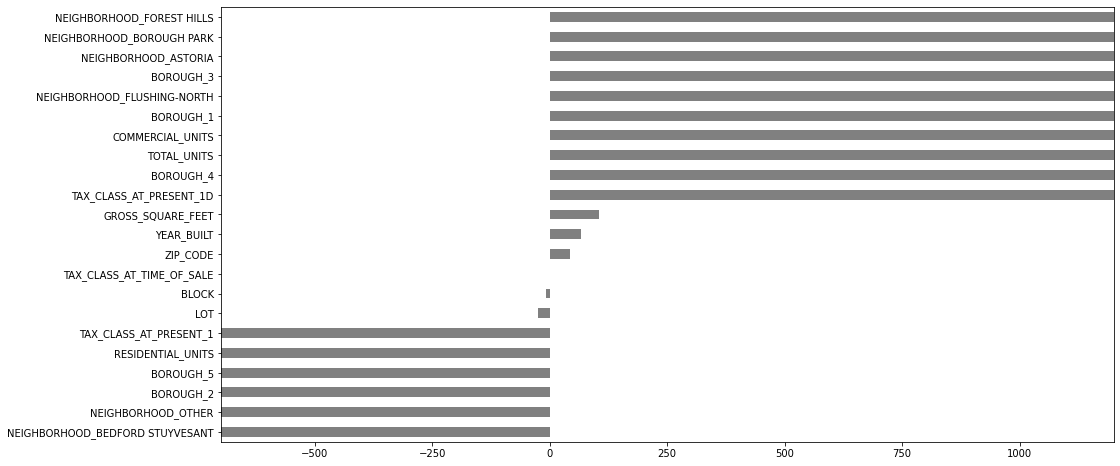

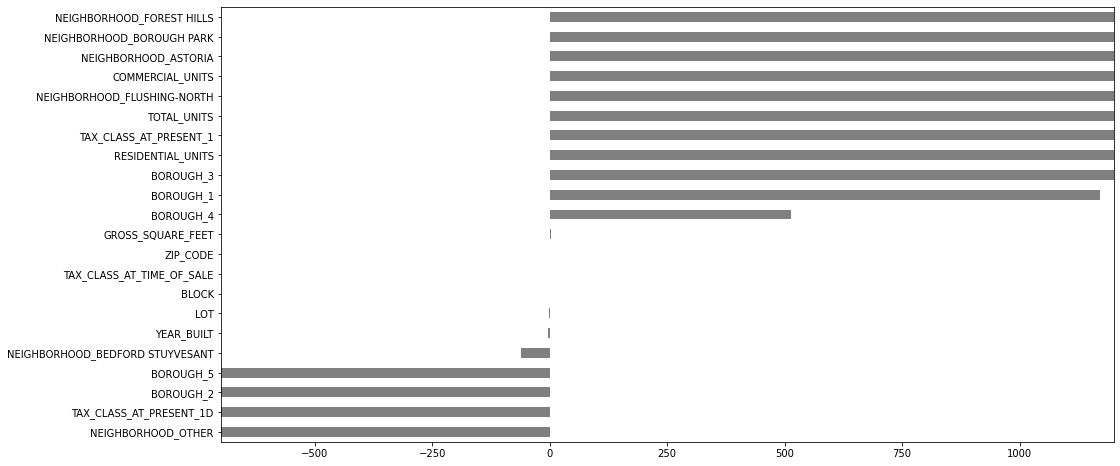

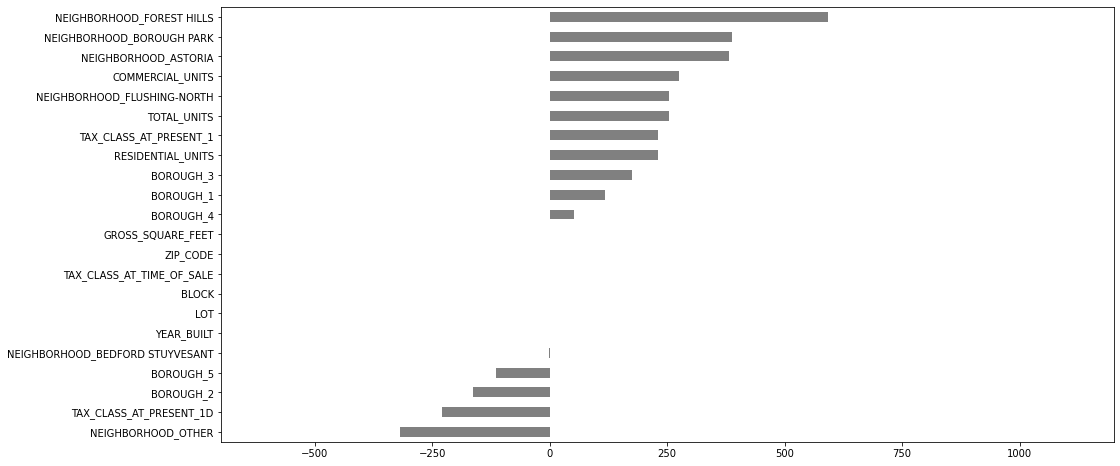

In [92]:
##Fit a ridge regression model with multiple features. Use the normalize=True parameter 
##(or do feature scaling beforehand — use the scaler's fit_transform method with 
##the train set, and the scaler's transform method with the test set)

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train_enc.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-700,1200)
    plt.show()

In [93]:
##Stretch: Try RidgeCV
from sklearn.linear_model import RidgeCV
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train_enc, y_train)
ridge.alpha_

0.01